In [1]:
# =========================
# Colab: Dataset download + loading (StoryReasoning)
# Project 1 (Graph Reasoning)
# =========================

# 1) Install deps (restart runtime if Colab asks after install)
!pip -q install -U datasets huggingface_hub pillow pandas matplotlib tqdm

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradio 5.50.0 requires pillow<12.0,>=8.0, but you have pillow 12.0.0 which is incompatible.
transformers 4.57.3 requires huggingface-hub<1.0,>=0.34.0, but you have huggingface-hub 1.2.3 which is incompatible.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['story_id', 'images', 'frame_count', 'chain_of_thought', 'story'],
        num_rows: 3552
    })
    test: Dataset({
        features: ['story_id', 'images', 'frame_count', 'chain_of_thought', 'story'],
        num_rows: 626
    })
})

--- Split: train ---
Num rows: 3552
Columns: ['story_id', 'images', 'frame_count', 'chain_of_thought', 'story']
Features: {'story_id': Value('string'), 'images': List(Image(mode=None, decode=True)), 'frame_count': Value('int32'), 'chain_of_thought': Value('string'), 'story': Value('string')}

--- Split: test ---
Num rows: 626
Columns: ['story_id', 'images', 'frame_count', 'chain_of_thought', 'story']
Features: {'story_id': Value('string'), 'images': List(Image(mode=None, decode=True)), 'frame_count': Value('int32'), 'chain_of_thought': Value('string'), 'story': Value('string')}

Sample keys: ['story_id', 'images', 'frame_count', 'chain_of_thought', 'story']


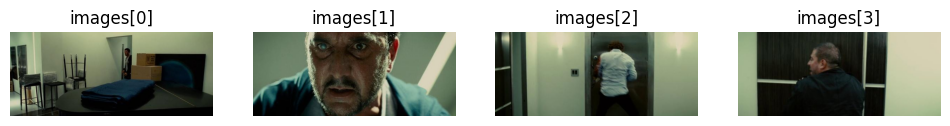


Missing-rate (approx) for split train:
story_id            0.0
images              0.0
frame_count         0.0
chain_of_thought    0.0
story               0.0
dtype: float64

Missing-rate (approx) for split test:
story_id            0.0
images              0.0
frame_count         0.0
chain_of_thought    0.0
story               0.0
dtype: float64


In [2]:
import os
from datasets import load_dataset

# 2) (Optional) If you have a HF token (for rate limits / private datasets)
# from google.colab import userdata
# os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")  # store in Colab Secrets

# 3) Choose cache dir (Colab local is fastest)
CACHE_DIR = "/content/hf_cache"
os.makedirs(CACHE_DIR, exist_ok=True)

# 4) Load StoryReasoning from Hugging Face
# Dataset ID confirmed: "daniel3303/StoryReasoning"
# This will download and cache the dataset locally in CACHE_DIR.
ds = load_dataset(
    "daniel3303/StoryReasoning",
    cache_dir=CACHE_DIR
)

print(ds)

# 5) Inspect splits and schema/features
for split in ds.keys():
    print(f"\n--- Split: {split} ---")
    print("Num rows:", len(ds[split]))
    print("Columns:", ds[split].column_names)
    print("Features:", ds[split].features)

# 6) Peek at a sample (keys vary; print full dict keys first)
sample = ds[list(ds.keys())[0]][0]
print("\nSample keys:", list(sample.keys()))

# 7) If the dataset contains images stored as `datasets.Image`,
# you can visualize them directly with PIL.
from PIL import Image
import matplotlib.pyplot as plt

def show_any_images(example):
    # Try common field names; adjust after you inspect sample keys above.
    candidate_fields = ["images", "image", "frames", "imgs", "visuals"]
    for field in candidate_fields:
        if field in example:
            x = example[field]
            # x might be a single image or a list of images
            if isinstance(x, list) and len(x) > 0:
                # show first few
                n = min(4, len(x))
                plt.figure(figsize=(12, 3))
                for i in range(n):
                    plt.subplot(1, n, i + 1)
                    img = x[i]
                    # HF Image objects can be dict-like or PIL already
                    if hasattr(img, "convert"):
                        pil = img
                    elif isinstance(img, dict) and "path" in img:
                        pil = Image.open(img["path"]).convert("RGB")
                    elif isinstance(img, dict) and "bytes" in img and img["bytes"] is not None:
                        import io
                        pil = Image.open(io.BytesIO(img["bytes"])).convert("RGB")
                    else:
                        # last resort: try casting
                        pil = Image.fromarray(img)
                    plt.imshow(pil)
                    plt.axis("off")
                    plt.title(f"{field}[{i}]")
                plt.show()
                return
            else:
                # single image
                img = x
                if hasattr(img, "convert"):
                    pil = img
                elif isinstance(img, dict) and "path" in img:
                    pil = Image.open(img["path"]).convert("RGB")
                elif isinstance(img, dict) and "bytes" in img and img["bytes"] is not None:
                    import io
                    pil = Image.open(io.BytesIO(img["bytes"])).convert("RGB")
                else:
                    pil = Image.fromarray(img)
                plt.figure(figsize=(4,4))
                plt.imshow(pil)
                plt.axis("off")
                plt.title(field)
                plt.show()
                return
    print("No obvious image field found. Inspect sample keys and update candidate_fields.")

show_any_images(sample)

# 8) Quick sanity checks: missing values per column (lightweight)
import pandas as pd

def missing_report(split_name, n=1000):
    # sample subset for speed
    sub = ds[split_name].select(range(min(n, len(ds[split_name]))))
    df = pd.DataFrame(sub)
    # some columns may be non-scalar (lists/dicts); still counts None
    miss = df.isna().mean().sort_values(ascending=False)
    return miss

for split in ds.keys():
    print(f"\nMissing-rate (approx) for split {split}:")
    print(missing_report(split))

# 9) OPTIONAL: Stream mode (useful if you want to avoid full download)
# NOTE: Streaming means you can't do len(ds) and random access the same way.
# ds_stream = load_dataset("daniel3303/StoryReasoning", streaming=True)
# print(ds_stream)


Train rows: 3552 Test rows: 626
Columns: ['story_id', 'images', 'frame_count', 'chain_of_thought', 'story']


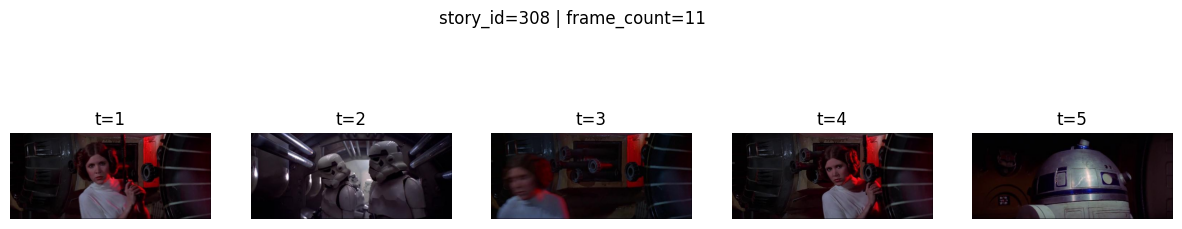

STORY (raw):
<gdi image1>
In the heart of a metallic, industrial setting, <gdo char2>C-3PO</gdo> stood solemnly, <gda char2>reflecting</gda> on the events that had led <gdo char2>him</gdo> to this place. The <gdo bg3>section of a metallic wall</gdo> loomed behind <gdo char2>him</gdo>, a silent witness to the unfolding drama. <gdo char2>C-3PO</gdo> was more than just a protocol droid; <gdo char2>he</gdo> was a guardian of secrets, a keeper of knowledge that could change the course of history. <gdo char2>His</gdo> circuits buzzed with anticipation as <gdo char2>he</gdo> prepared for the mission ahead.
</gdi>

<gdi image2>
The metallic walls of the facility seemed to close in, creating an oppressive atmosphere. <gdo char2>C-3PO</gdo> <gda char2>scanned</gda> the environment, <gdo char2>his</gdo> sensors picking up the faint hum of machinery and the distant echo of footsteps. <gdo char2>He</gdo> knew that <gdo char2>he</gdo> was not alone in this place. The <gdo bg2>section of a metallic w

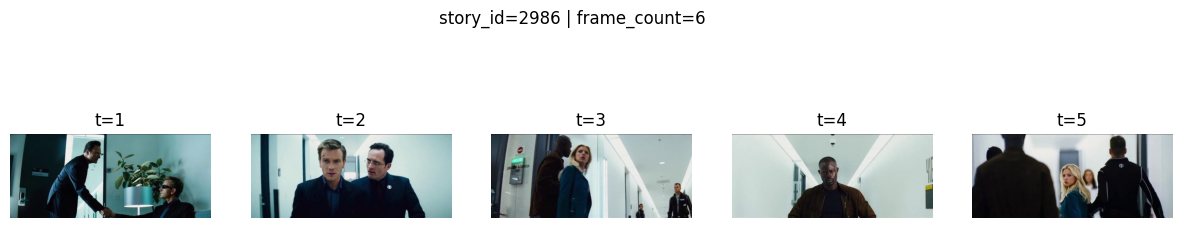

STORY (raw):
<gdi image1>
In the sleek, modern hallway of a high-security institution, <gdo char4>Alan</gdo> and <gdo char9>Mark</gdo> shook hands, a gesture laden with the weight of an unsaid pact. The <gdo obj1>potted plant</gdo> stood as a silent witness to their agreement, a small patch of life amidst the sterile environment. <gdo char4>Alan</gdo> felt a knot in his stomach as <gdo char4>he</gdo> glanced at <gdo char9>Mark</gdo>'s sunglasses, obscuring <gdo char9>his</gdo> eyes and adding a layer of mystery. <gdo char9>Mark</gdo> exuded an air of nonchalant power, and <gdo char4>Alan</gdo> couldn't help but wonder what secrets <gdo char9>he</gdo> kept behind that cool exterior. The <gdo obj2>door</gdo> near <gdo char4>Alan</gdo> seemed to beckon, promising a world beyond this sterile place.
</gdi>

<gdi image2>
After the handshake, <gdo char4>Alan</gdo> and <gdo char8>James</gdo> walked through the <gdl bg1>modern, clean hallway</gdl> with a sense of purpose. The <gdo char8>confuse

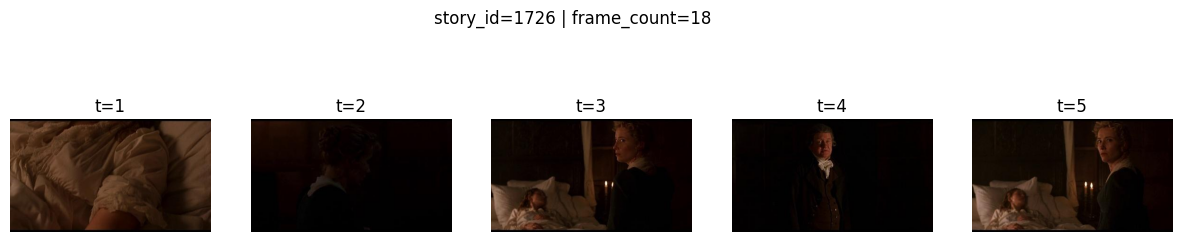

STORY (raw):
<gdi image1>
In the quiet <gdl bg1>indoor setting</gdl>, <gdo char1>Alice</gdo> stood alone, her curly blonde hair framing her face as <gdo char1>she</gdo> gazed into the distance. The <gdo bg1>background wall</gdo> seemed to echo the silence that enveloped <gdo char1>her</gdo>. <gdo char1>She</gdo> had always been a solitary figure, but today, something felt different. A sense of unease gnawed at <gdo char1>her</gdo> as <gdo char1>she</gdo> prepared for the events that were about to unfold.
</gdi>

<gdi image2>
The atmosphere shifted as <gdo char1>Alice</gdo> moved through the space, the <gdo bg2>wooden wall on the left</gdo> and <gdo bg11>wooden wall on the right</gdo> framing <gdo char1>her</gdo> path. <gdo char1>She</gdo> felt the weight of expectations pressing down on <gdo char1>her</gdo> shoulders. <gdo char1>She</gdo> knew that today would be the day <gdo char1>she</gdo> would confront the past and face the truth.
</gdi>

<gdi image3>
As <gdo char1>Alice</gdo> ente

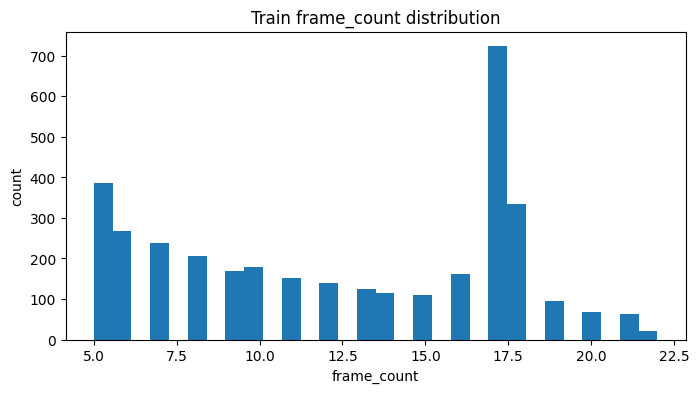

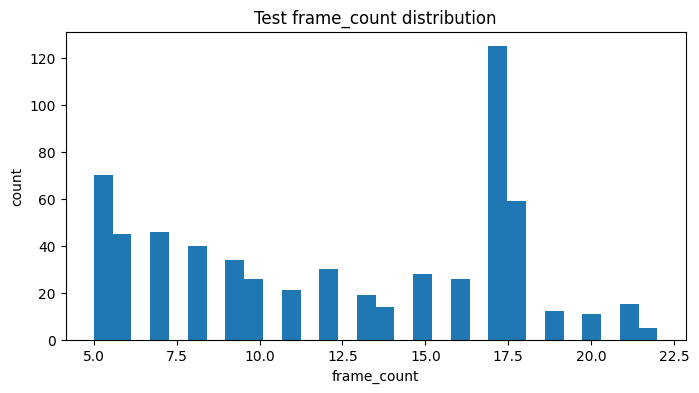

/tmp/ipython-input-2362704610.py:85: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([fc_train, fc_test], labels=["train", "test"])


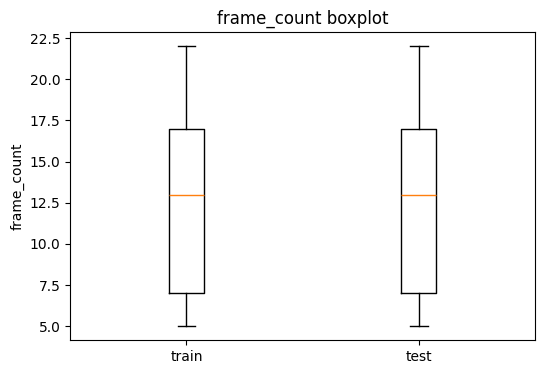

Lengths: story:   0%|          | 0/1200 [00:00<?, ?it/s]

Lengths: chain_of_thought:   0%|          | 0/1200 [00:00<?, ?it/s]

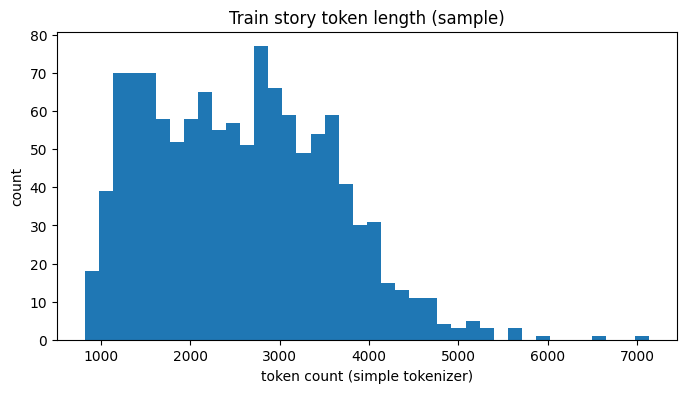

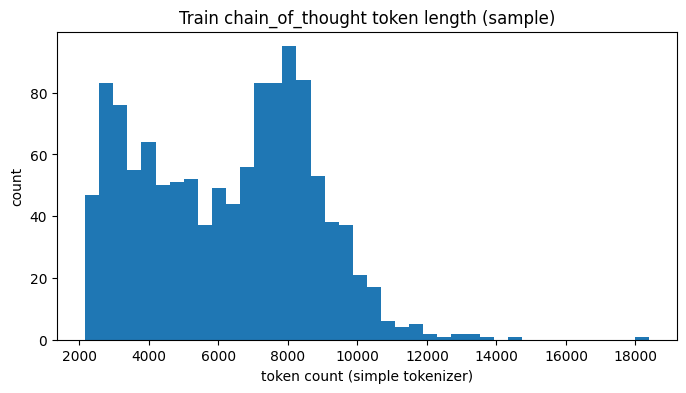

Scatter sample:   0%|          | 0/1200 [00:00<?, ?it/s]

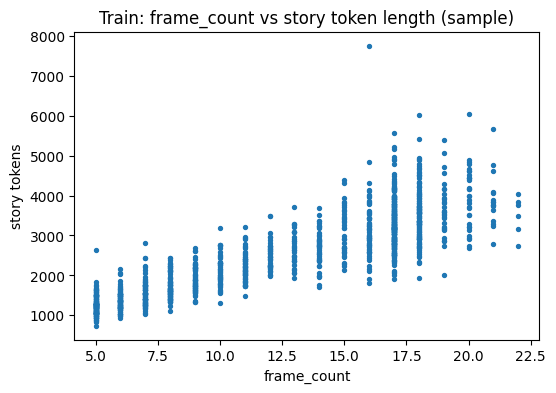

Keyword counts in story:   0%|          | 0/1500 [00:00<?, ?it/s]

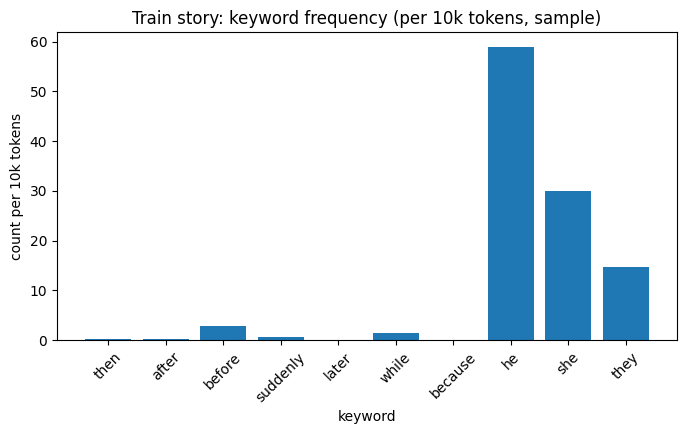

Entity-ish EDA (Capitalized words in CoT):   0%|          | 0/800 [00:00<?, ?it/s]

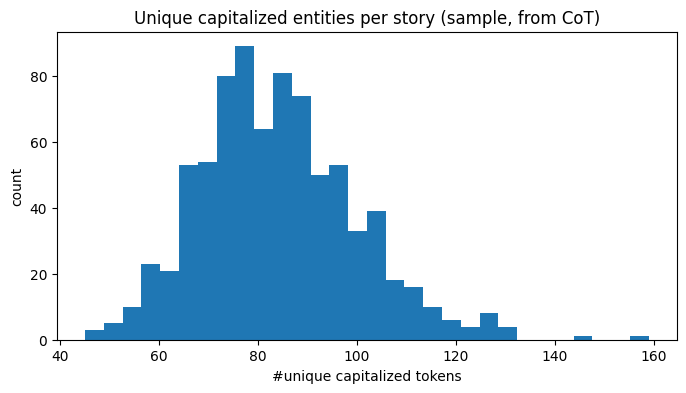

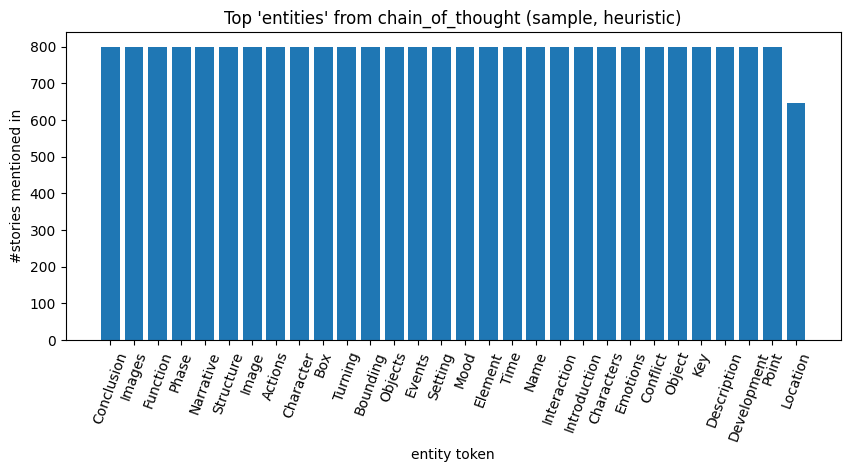

In [3]:
# =========================
# Colab: Inspect + EDA for StoryReasoning dataset
# Uses your confirmed schema:
# ['story_id', 'images', 'frame_count', 'chain_of_thought', 'story']
# =========================

!pip -q install -U pandas matplotlib tqdm pillow datasets

import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from datasets import load_dataset

CACHE_DIR = "/content/hf_cache"

ds = load_dataset("daniel3303/StoryReasoning", cache_dir=CACHE_DIR)

train = ds["train"]
test  = ds["test"]

print("Train rows:", len(train), "Test rows:", len(test))
print("Columns:", train.column_names)

# -------------------------
# 1) Visualize a few stories
# -------------------------
from PIL import Image

def show_story(split, idx, max_frames=6):
    ex = split[idx]
    imgs = ex["images"][:max_frames]
    story_id = ex["story_id"]
    fc = ex["frame_count"]
    story = ex["story"]

    n = len(imgs)
    plt.figure(figsize=(3*n, 3))
    for i in range(n):
        plt.subplot(1, n, i+1)
        pil = imgs[i]
        if not hasattr(pil, "convert"):
            # HF Image usually decodes to PIL already; fallback
            pil = Image.fromarray(np.array(pil))
        plt.imshow(pil.convert("RGB"))
        plt.axis("off")
        plt.title(f"t={i+1}")
    plt.suptitle(f"story_id={story_id} | frame_count={fc}", y=1.05, fontsize=12)
    plt.show()

    print("STORY (raw):")
    print(story[:1500] + ("..." if len(story) > 1500 else ""))
    print("\nCHAIN OF THOUGHT (raw):")
    cot = ex["chain_of_thought"]
    print(cot[:1500] + ("..." if len(cot) > 1500 else ""))

# Show a few random stories from train
import random
random_idxs = random.sample(range(len(train)), k=3)
for idx in random_idxs:
    show_story(train, idx, max_frames=5)

# -------------------------
# 2) Basic numeric EDA: frame_count distribution
# -------------------------
# Efficiently pull just the frame_count column
fc_train = train["frame_count"]
fc_test  = test["frame_count"]

def plot_hist(data, title, bins=30):
    plt.figure(figsize=(8,4))
    plt.hist(data, bins=bins)
    plt.title(title)
    plt.xlabel("frame_count")
    plt.ylabel("count")
    plt.show()

plot_hist(fc_train, "Train frame_count distribution")
plot_hist(fc_test,  "Test frame_count distribution")

# Boxplot for quick comparison
plt.figure(figsize=(6,4))
plt.boxplot([fc_train, fc_test], labels=["train", "test"])
plt.title("frame_count boxplot")
plt.ylabel("frame_count")
plt.show()

# -------------------------
# 3) Text EDA: story + chain_of_thought length stats
# -------------------------
def basic_tokenize(s: str):
    # simple whitespace tokenization (fast, model-agnostic)
    return re.findall(r"\w+|[^\w\s]", s.lower())

def text_lengths(split, field, sample_n=None, seed=0):
    n = len(split) if sample_n is None else min(sample_n, len(split))
    rng = np.random.default_rng(seed)
    idxs = np.arange(len(split))
    if sample_n is not None:
        idxs = rng.choice(idxs, size=n, replace=False)
    lengths = []
    for i in tqdm(idxs, desc=f"Lengths: {field}"):
        txt = split[int(i)][field]
        lengths.append(len(basic_tokenize(txt)))
    return np.array(lengths)

# For speed in Colab, start with a sample; set sample_n=None for full pass
story_len_train = text_lengths(train, "story", sample_n=1200, seed=42)
cot_len_train   = text_lengths(train, "chain_of_thought", sample_n=1200, seed=42)

def plot_len_hist(arr, title, bins=40):
    plt.figure(figsize=(8,4))
    plt.hist(arr, bins=bins)
    plt.title(title)
    plt.xlabel("token count (simple tokenizer)")
    plt.ylabel("count")
    plt.show()

plot_len_hist(story_len_train, "Train story token length (sample)")
plot_len_hist(cot_len_train,   "Train chain_of_thought token length (sample)")

# Scatter: frame_count vs story length (sample)
# (pull matching frame_counts for the same sampled indices)
# We'll re-sample with stored indices to align properly
def sample_pairs_for_scatter(split, n=1000, seed=123):
    rng = np.random.default_rng(seed)
    idxs = rng.choice(np.arange(len(split)), size=min(n, len(split)), replace=False)
    x_fc = []
    y_len = []
    for i in tqdm(idxs, desc="Scatter sample"):
        ex = split[int(i)]
        x_fc.append(ex["frame_count"])
        y_len.append(len(basic_tokenize(ex["story"])))
    return np.array(x_fc), np.array(y_len)

x_fc, y_len = sample_pairs_for_scatter(train, n=1200, seed=7)
plt.figure(figsize=(6,4))
plt.scatter(x_fc, y_len, s=8)
plt.title("Train: frame_count vs story token length (sample)")
plt.xlabel("frame_count")
plt.ylabel("story tokens")
plt.show()

# -------------------------
# 4) Quick keyword frequency plots (temporal / entity-ish cues)
# -------------------------
KEYWORDS = ["then", "after", "before", "suddenly", "later", "while", "because", "he", "she", "they"]

def keyword_counts(split, field="story", sample_n=1500, seed=0):
    rng = np.random.default_rng(seed)
    idxs = rng.choice(np.arange(len(split)), size=min(sample_n, len(split)), replace=False)
    counts = {k: 0 for k in KEYWORDS}
    total_tokens = 0
    for i in tqdm(idxs, desc=f"Keyword counts in {field}"):
        tokens = basic_tokenize(split[int(i)][field])
        total_tokens += len(tokens)
        for k in KEYWORDS:
            counts[k] += tokens.count(k)
    return counts, total_tokens

counts, total = keyword_counts(train, "story", sample_n=1500, seed=1)
df_kw = pd.DataFrame({"keyword": list(counts.keys()), "count": list(counts.values())})
df_kw["per_10k_tokens"] = df_kw["count"] / max(total, 1) * 10000

plt.figure(figsize=(8,4))
plt.bar(df_kw["keyword"], df_kw["per_10k_tokens"])
plt.title("Train story: keyword frequency (per 10k tokens, sample)")
plt.xlabel("keyword")
plt.ylabel("count per 10k tokens")
plt.xticks(rotation=45)
plt.show()

# -------------------------
# 5) Parse chain_of_thought for entity-ish structure (light heuristic)
# No assumptions about formatting; we extract:
# - Proper-noun-like tokens (Capitalized words) from the raw CoT
# This is crude, but helps EDA before building real entity extraction.
# -------------------------
CAP_RE = re.compile(r"\b[A-Z][a-z]{2,}\b")

def extract_capitalized_entities(text):
    return CAP_RE.findall(text)

def entity_eda(split, sample_n=800, seed=0):
    rng = np.random.default_rng(seed)
    idxs = rng.choice(np.arange(len(split)), size=min(sample_n, len(split)), replace=False)
    ent_counts = []
    top_counter = {}
    for i in tqdm(idxs, desc="Entity-ish EDA (Capitalized words in CoT)"):
        cot = split[int(i)]["chain_of_thought"]
        ents = extract_capitalized_entities(cot)
        ent_counts.append(len(set(ents)))
        for e in set(ents):
            top_counter[e] = top_counter.get(e, 0) + 1
    # top 30
    top = sorted(top_counter.items(), key=lambda x: x[1], reverse=True)[:30]
    return np.array(ent_counts), pd.DataFrame(top, columns=["entity", "stories_mentioned_in"])

ent_counts, df_top = entity_eda(train, sample_n=800, seed=2)

plt.figure(figsize=(8,4))
plt.hist(ent_counts, bins=30)
plt.title("Unique capitalized entities per story (sample, from CoT)")
plt.xlabel("#unique capitalized tokens")
plt.ylabel("count")
plt.show()

plt.figure(figsize=(10,4))
plt.bar(df_top["entity"], df_top["stories_mentioned_in"])
plt.title("Top 'entities' from chain_of_thought (sample, heuristic)")
plt.xlabel("entity token")
plt.ylabel("#stories mentioned in")
plt.xticks(rotation=70)
plt.show()

# -------------------------
# 6) Save EDA artifacts (optional)
# -------------------------
OUT_DIR = "/content/results_eda"
os.makedirs(OUT_DIR, exist_ok=True)


In [4]:
import os
import re
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from datasets import load_dataset
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader

CACHE_DIR = "/content/hf_cache"
ds = load_dataset("daniel3303/StoryReasoning", cache_dir=CACHE_DIR)

train_raw = ds["train"]
test_raw  = ds["test"]

# -------------------------
# 1) Train/Val split by story_id
# -------------------------
unique_ids = np.unique(np.array(train_raw["story_id"]))
VAL_FRAC = 0.10
SEED = 42

train_ids, val_ids = train_test_split(
    unique_ids,
    test_size=VAL_FRAC,
    random_state=SEED,
    shuffle=True
)
train_id_set = set(train_ids.tolist())
val_id_set   = set(val_ids.tolist())

# Map story_id -> row index in the original split (one row per story)
# In your dataset each row is a story, so this mapping is direct.
storyid_to_idx_trainraw = {sid: i for i, sid in enumerate(train_raw["story_id"])}

train_story_indices = [storyid_to_idx_trainraw[sid] for sid in train_ids]
val_story_indices   = [storyid_to_idx_trainraw[sid] for sid in val_ids]

print("Train stories:", len(train_story_indices), "Val stories:", len(val_story_indices), "Test stories:", len(test_raw))

# -------------------------
# 2) Frame-text extraction: marker-splitting failed (0%), so use story->frames split
#    We'll compute per-frame text lazily too.
# -------------------------
_sentence_re = re.compile(r"(?<=[\.\!\?])\s+")

def split_story_into_frames(story: str, frame_count: int):
    sents = [s.strip() for s in _sentence_re.split((story or "").strip()) if s.strip()]
    if frame_count <= 0:
        return []
    if not sents:
        return [""] * frame_count
    chunks = [[] for _ in range(frame_count)]
    for i, sent in enumerate(sents):
        chunks[i * frame_count // len(sents)].append(sent)
    return [" ".join(c).strip() for c in chunks]

# -------------------------
# 3) Build a lightweight index table: (story_row_idx, t_index)
#    This is tiny: just integers.
# -------------------------
K = 4

def build_index_table(split, story_row_indices, K=4, limit_samples=None):
    rows = []
    added = 0
    for row_idx in tqdm(story_row_indices, desc="Indexing stories"):
        ex = split[int(row_idx)]
        fc = int(ex["frame_count"])
        if fc < K + 1:
            continue
        # windows: predict t from [t-K..t-1]
        for t in range(K, fc):
            rows.append((int(row_idx), int(t), int(fc)))
            added += 1
            if limit_samples is not None and added >= limit_samples:
                return rows
    return rows

# NOTE: train_raw is the split we're indexing for train/val
train_index = build_index_table(train_raw, train_story_indices, K=K, limit_samples=None)
val_index   = build_index_table(train_raw, val_story_indices,   K=K, limit_samples=None)

# test_raw is separate, story index is row index within test_raw
test_story_indices = list(range(len(test_raw)))
test_index  = build_index_table(test_raw, test_story_indices, K=K, limit_samples=None)

print("Train samples:", len(train_index), "Val samples:", len(val_index), "Test samples:", len(test_index))

# -------------------------
# 4) PyTorch dataset that fetches images/text lazily from the base dataset
# -------------------------
class StoryReasoningWindowDataset(Dataset):
    def __init__(self, base_split, index_rows, K=4):
        self.base = base_split
        self.index = index_rows
        self.K = K

    def __len__(self):
        return len(self.index)

    def __getitem__(self, i):
        row_idx, t, fc = self.index[i]
        ex = self.base[row_idx]

        imgs = ex["images"]  # list of PIL images (decoded on access)
        story_id = ex["story_id"]
        story = ex["story"]

        # per-frame text from story (fallback you need since markers don't exist)
        frame_texts = split_story_into_frames(story, int(ex["frame_count"]))

        ctx_imgs  = imgs[t-self.K:t]
        tgt_img  = imgs[t]
        ctx_txts = frame_texts[t-self.K:t]
        tgt_txt  = frame_texts[t]

        return {
            "story_id": story_id,
            "row_idx": row_idx,
            "t_index": t,
            "frame_count": fc,
            "ctx_images": ctx_imgs,      # list of PIL
            "target_image": tgt_img,     # PIL
            "ctx_texts": ctx_txts,       # list[str]
            "target_text": tgt_txt       # str
        }

# Simple collate that keeps PIL + strings as lists (no tensor conversion yet)
def collate_keep_raw(batch):
    out = {}
    for k in batch[0].keys():
        out[k] = [b[k] for b in batch]
    return out

train_ds = StoryReasoningWindowDataset(train_raw, train_index, K=K)
val_ds   = StoryReasoningWindowDataset(train_raw, val_index,   K=K)
test_ds  = StoryReasoningWindowDataset(test_raw,  test_index,  K=K)

print("Torch datasets:", len(train_ds), len(val_ds), len(test_ds))

# -------------------------
# 5) DataLoaders (keep num_workers=0 in Colab to avoid PIL multiprocessing issues)
#    batch_size small for now; later adjust after embedding pipeline is in place.
# -------------------------
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=0, collate_fn=collate_keep_raw)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, num_workers=0, collate_fn=collate_keep_raw)

# Quick sanity: iterate one batch without crashing RAM
batch = next(iter(train_loader))
print("Batch keys:", batch.keys())
print("Batch story_id example:", batch["story_id"][0])
print("ctx_images lens:", [len(x) for x in batch["ctx_images"]])
print("First target_text snippet:", batch["target_text"][0][:200])


Train stories: 3196 Val stories: 356 Test stories: 626


Indexing stories:   0%|          | 0/3196 [00:00<?, ?it/s]

Indexing stories:   0%|          | 0/356 [00:00<?, ?it/s]

Indexing stories:   0%|          | 0/626 [00:00<?, ?it/s]

Train samples: 27107 Val samples: 2884 Test samples: 5254
Torch datasets: 27107 2884 5254
Batch keys: dict_keys(['story_id', 'row_idx', 't_index', 'frame_count', 'ctx_images', 'target_image', 'ctx_texts', 'target_text'])
Batch story_id example: 2315
ctx_images lens: [4, 4, 4, 4]
First target_text snippet: <gdo char4>The Hand</gdo> moved through <gdl lm1>the hallway</gdl> with a sense of purpose, <gdo obj1>the stone walls</gdo> echoing with <gdo char4>the</gdo> footsteps. The silence was oppressive, the


In [8]:

!pip -q install -U torch torchvision transformers accelerate safetensors tqdm scikit-learn datasets pillow

In [12]:
# =========================
# COMPLETE COLAB CELL (NO HF MODELS):
# ResNet18 (vision) + TF-IDF (text) embeddings + GRU baseline training
# Requires: train_ds, val_ds already defined
# =========================

!pip -q install -U torch torchvision scikit-learn tqdm pillow

import os
import re
import numpy as np
from tqdm.auto import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import models, transforms
from sklearn.feature_extraction.text import TfidfVectorizer

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# -------------------------
# 0) Text cleaning (remove dataset tags)
# -------------------------
TAG_RE = re.compile(r"</?g(?:do|di)[^>]*>", flags=re.IGNORECASE)

def clean_text(s: str) -> str:
    s = s or ""
    s = TAG_RE.sub(" ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

# -------------------------
# 1) Vision encoder: ResNet18 -> 512-d features
#    (No HF; uses torchvision weights)
# -------------------------
weights = models.ResNet18_Weights.DEFAULT
resnet = models.resnet18(weights=weights)
resnet.fc = nn.Identity()  # output: [B, 512]
resnet = resnet.to(device).eval()
for p in resnet.parameters():
    p.requires_grad_(False)

IMG_DIM = 512

img_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=weights.transforms().mean, std=weights.transforms().std),
])

@torch.no_grad()
def encode_images_resnet(pil_images):
    # pil_images: list[PIL.Image]
    batch = torch.stack([img_tf(im.convert("RGB")) for im in pil_images], dim=0).to(device)
    feats = resnet(batch)  # [B, 512]
    return F.normalize(feats, dim=-1)

# -------------------------
# 2) Text encoder: TF-IDF -> dense projection
#    Fit vectorizer on a sample of train text to keep RAM/time sane
# -------------------------
# Build a corpus from train_ds (sample) using only the target_text + context texts
# NOTE: Increase N_CORPUS if you want better vocab (costs time/RAM)
N_CORPUS = min(6000, len(train_ds))
rng = np.random.default_rng(0)
sample_idxs = rng.choice(np.arange(len(train_ds)), size=N_CORPUS, replace=False)

corpus = []
for i in tqdm(sample_idxs, desc="Building TF-IDF corpus"):
    ex = train_ds[int(i)]
    corpus.extend([clean_text(t) for t in ex["ctx_texts"]])
    corpus.append(clean_text(ex["target_text"]))

# Cap features to keep memory stable
TFIDF_MAX_FEATURES = 8000
vectorizer = TfidfVectorizer(
    max_features=TFIDF_MAX_FEATURES,
    ngram_range=(1, 2),
    min_df=2
)
vectorizer.fit(corpus)
TXT_DIM_RAW = len(vectorizer.get_feature_names_out())
print("TF-IDF vocab size:", TXT_DIM_RAW)

def tfidf_transform(text_list):
    # returns float32 dense numpy array [N, V]
    X = vectorizer.transform(text_list)
    return X.toarray().astype(np.float32)

# We'll project TF-IDF vectors down to TXT_DIM (trainable)
TXT_DIM = 512

# -------------------------
# 3) Collate: raw batch -> tensors
#    Produces:
#      ctx_img_emb: [B, K, 512]
#      ctx_txt_vec: [B, K, V]   (TF-IDF raw)
#      tgt_img_emb: [B, 512]
#      tgt_txt_vec: [B, V]
# -------------------------
def collate_resnet_tfidf(batch, K=4):
    B = len(batch)

    # Flatten context images/texts for embedding
    ctx_images_flat = []
    ctx_texts_flat  = []
    tgt_images = []
    tgt_texts  = []

    for b in batch:
        ctx_images = b["ctx_images"]
        ctx_texts  = b["ctx_texts"]
        if len(ctx_images) != K or len(ctx_texts) != K:
            raise ValueError(f"Expected K={K}, got {len(ctx_images)} images and {len(ctx_texts)} texts")
        ctx_images_flat.extend(ctx_images)
        ctx_texts_flat.extend([clean_text(t) for t in ctx_texts])
        tgt_images.append(b["target_image"])
        tgt_texts.append(clean_text(b["target_text"]))

    # Image embeddings (ResNet)
    ctx_img_emb_flat = encode_images_resnet(ctx_images_flat)  # [B*K, 512]
    tgt_img_emb      = encode_images_resnet(tgt_images)       # [B, 512]

    # Text TF-IDF (CPU numpy -> torch)
    ctx_txt_raw = tfidf_transform(ctx_texts_flat)             # [B*K, V]
    tgt_txt_raw = tfidf_transform(tgt_texts)                  # [B, V]

    ctx_txt_raw = torch.from_numpy(ctx_txt_raw)               # CPU tensor
    tgt_txt_raw = torch.from_numpy(tgt_txt_raw)

    # reshape context
    ctx_img_emb = ctx_img_emb_flat.view(B, K, -1).contiguous()            # GPU
    ctx_txt_raw = ctx_txt_raw.view(B, K, -1).contiguous().to(device)     # move to GPU
    tgt_txt_raw = tgt_txt_raw.to(device)

    return {
        "ctx_img_emb": ctx_img_emb,   # [B, K, 512] (GPU)
        "ctx_txt_raw": ctx_txt_raw,   # [B, K, V]   (GPU)
        "tgt_img_emb": tgt_img_emb,   # [B, 512]    (GPU)
        "tgt_txt_raw": tgt_txt_raw,   # [B, V]      (GPU)
    }

# -------------------------
# 4) Model: project TF-IDF -> 512, fuse with image -> GRU -> predict next img/txt embeddings
# -------------------------
class ResnetTfidfSeqPredictor(nn.Module):
    def __init__(self, img_dim=512, tfidf_dim=8000, txt_dim=512, hidden_dim=512, dropout=0.1):
        super().__init__()
        self.txt_proj = nn.Sequential(
            nn.Linear(tfidf_dim, txt_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.in_proj = nn.Sequential(
            nn.Linear(img_dim + txt_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.out_img = nn.Linear(hidden_dim, img_dim)
        self.out_txt = nn.Linear(hidden_dim, txt_dim)

    def forward(self, ctx_img_emb, ctx_txt_raw):
        # ctx_img_emb: [B,K,512]
        # ctx_txt_raw: [B,K,V]
        ctx_txt = self.txt_proj(ctx_txt_raw)                 # [B,K,512]
        x = torch.cat([ctx_img_emb, ctx_txt], dim=-1)        # [B,K,1024]
        x = self.in_proj(x)                                  # [B,K,H]
        _, hN = self.gru(x)
        h = hN.squeeze(0)                                    # [B,H]
        pred_img = F.normalize(self.out_img(h), dim=-1)      # [B,512]
        pred_txt = F.normalize(self.out_txt(h), dim=-1)      # [B,512]
        return pred_img, pred_txt

def cosine_loss(pred, target):
    return (1.0 - (pred * target).sum(dim=-1)).mean()

# Targets:
# - image target is already 512 normalized
# - text target: project TF-IDF -> 512 then normalize for cosine target
# We'll compute text targets via the model's txt_proj but detached.
@torch.no_grad()
def make_txt_target(model, tgt_txt_raw):
    tgt = model.txt_proj(tgt_txt_raw)
    return F.normalize(tgt, dim=-1)

# -------------------------
# 5) DataLoaders + training loop with tqdm
# -------------------------
K = 4
BATCH_SIZE = 8  # reduce to 4 if GPU memory is tight
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0,
                          collate_fn=lambda b: collate_resnet_tfidf(b, K=K))
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0,
                          collate_fn=lambda b: collate_resnet_tfidf(b, K=K))

model = ResnetTfidfSeqPredictor(
    img_dim=IMG_DIM,
    tfidf_dim=TXT_DIM_RAW,
    txt_dim=TXT_DIM,
    hidden_dim=512,
    dropout=0.1
).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)

@torch.no_grad()
def eval_epoch(loader):
    model.eval()
    tot = 0
    sum_li = sum_lt = 0.0
    sum_ci = sum_ct = 0.0

    for batch in tqdm(loader, desc="val", leave=False):
        pred_i, pred_t = model(batch["ctx_img_emb"], batch["ctx_txt_raw"])
        tgt_t = make_txt_target(model, batch["tgt_txt_raw"])

        li = cosine_loss(pred_i, batch["tgt_img_emb"])
        lt = cosine_loss(pred_t, tgt_t)

        ci = (pred_i * batch["tgt_img_emb"]).sum(dim=-1).mean()
        ct = (pred_t * tgt_t).sum(dim=-1).mean()

        bs = batch["ctx_img_emb"].size(0)
        tot += bs
        sum_li += li.item() * bs
        sum_lt += lt.item() * bs
        sum_ci += ci.item() * bs
        sum_ct += ct.item() * bs

    return {
        "val_loss_img": sum_li / max(tot, 1),
        "val_loss_txt": sum_lt / max(tot, 1),
        "val_cos_img":  sum_ci / max(tot, 1),
        "val_cos_txt":  sum_ct / max(tot, 1),
    }

EPOCHS = 3
SAVE_DIR = "/content/checkpoints_p1_resnet_tfidf"
os.makedirs(SAVE_DIR, exist_ok=True)

best_score = -1e9

for epoch in range(1, EPOCHS + 1):
    model.train()
    tot = 0
    sum_loss = sum_ci = sum_ct = 0.0

    pbar = tqdm(train_loader, desc=f"train epoch {epoch}", leave=True)
    for batch in pbar:
        pred_i, pred_t = model(batch["ctx_img_emb"], batch["ctx_txt_raw"])
        tgt_t = make_txt_target(model, batch["tgt_txt_raw"])

        li = cosine_loss(pred_i, batch["tgt_img_emb"])
        lt = cosine_loss(pred_t, tgt_t)
        loss = li + lt

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

        with torch.no_grad():
            ci = (pred_i * batch["tgt_img_emb"]).sum(dim=-1).mean()
            ct = (pred_t * tgt_t).sum(dim=-1).mean()

        bs = batch["ctx_img_emb"].size(0)
        tot += bs
        sum_loss += loss.item() * bs
        sum_ci += ci.item() * bs
        sum_ct += ct.item() * bs

        pbar.set_postfix({"loss": sum_loss/tot, "cos_i": sum_ci/tot, "cos_t": sum_ct/tot})

    metrics = eval_epoch(val_loader)
    score = metrics["val_cos_img"] + metrics["val_cos_txt"]

    print(f"\nEpoch {epoch} summary:")
    print(f"  train_loss={sum_loss/tot:.4f}  train_cos_img={sum_ci/tot:.4f}  train_cos_txt={sum_ct/tot:.4f}")
    print(f"  val_loss_img={metrics['val_loss_img']:.4f}  val_loss_txt={metrics['val_loss_txt']:.4f}")
    print(f"  val_cos_img={metrics['val_cos_img']:.4f}   val_cos_txt={metrics['val_cos_txt']:.4f}")

    ckpt_path = os.path.join(SAVE_DIR, f"epoch{epoch}.pt")
    torch.save({"epoch": epoch, "model_state": model.state_dict(), "opt_state": opt.state_dict(), "metrics": metrics}, ckpt_path)

    if score > best_score:
        best_score = score
        best_path = os.path.join(SAVE_DIR, "best.pt")
        torch.save({"epoch": epoch, "model_state": model.state_dict(), "opt_state": opt.state_dict(), "metrics": metrics}, best_path)
        print("  Saved best checkpoint:", best_path)

print("\nDone. Checkpoints in:", SAVE_DIR)


Device: cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:02<00:00, 18.8MB/s]


Building TF-IDF corpus:   0%|          | 0/6000 [00:00<?, ?it/s]

TF-IDF vocab size: 8000


train epoch 1:   0%|          | 0/3389 [00:00<?, ?it/s]

val:   0%|          | 0/361 [00:00<?, ?it/s]


Epoch 1 summary:
  train_loss=0.3878  train_cos_img=0.7934  train_cos_txt=0.8189
  val_loss_img=0.1977  val_loss_txt=0.1603
  val_cos_img=0.8023   val_cos_txt=0.8397
  Saved best checkpoint: /content/checkpoints_p1_resnet_tfidf/best.pt


train epoch 2:   0%|          | 0/3389 [00:00<?, ?it/s]

val:   0%|          | 0/361 [00:00<?, ?it/s]


Epoch 2 summary:
  train_loss=0.4158  train_cos_img=0.8050  train_cos_txt=0.7793
  val_loss_img=0.1948  val_loss_txt=0.2166
  val_cos_img=0.8052   val_cos_txt=0.7834

Done. Checkpoints in: /content/checkpoints_p1_resnet_tfidf


In [13]:
# =========================
# INNOVATION CELL:
# Graph reasoning from <gdo charX>NAME</gdo> tags + fusion into GRU
#
# What it does:
# 1) Extract entities per frame from tagged text (fast + reliable)
# 2) Build a graph per sample:
#    - nodes = unique entities in the K context frames (capped)
#    - node features = [type_onehot(CHAR/OBJ) + counts + first_seen + last_seen + tfidf-entity-name]
#    - edges = co-occurrence within same frame + temporal persistence edges
# 3) Message passing (simple gated graph conv; no external graph libs)
# 4) Pool graph -> graph embedding
# 5) Fuse graph embedding into GRU hidden state before prediction
#
# Requirements:
# - Run the ResNet+TFIDF baseline cell, so these exist:
#   train_ds, val_ds, encode_images_resnet, vectorizer, TXT_DIM_RAW, etc.
# =========================

import os
import re
import math
import numpy as np
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

# -------------------------
# Device
# -------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# -------------------------
# 0) Text cleaning + entity extraction from tags
# -------------------------
TAG_RE = re.compile(r"</?g(?:do|di)[^>]*>", flags=re.IGNORECASE)

# Capture entities like:
#   <gdo char2>Bob</gdo>
#   <gdo obj1>Knife</gdo>
ENT_RE = re.compile(r"<gdo\s+([^>]+)>(.*?)</gdo>", flags=re.IGNORECASE | re.DOTALL)

def clean_text(s: str) -> str:
    s = s or ""
    s = TAG_RE.sub(" ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def extract_entities_from_text(tagged_text: str):
    """
    Returns list of (etype, ename) where etype in {"char","obj","other"}.
    Deduplicates per text chunk.
    """
    tagged_text = tagged_text or ""
    ents = []
    for attrs, name in ENT_RE.findall(tagged_text):
        name = re.sub(r"\s+", " ", name).strip()
        if not name:
            continue
        attrs = attrs.lower()
        if "char" in attrs:
            etype = "char"
        elif "obj" in attrs:
            etype = "obj"
        else:
            etype = "other"
        ents.append((etype, name))
    # dedupe while preserving order
    seen = set()
    out = []
    for e in ents:
        if e not in seen:
            seen.add(e)
            out.append(e)
    return out

# -------------------------
# 1) Image encoder: ResNet18 (same as baseline)
#    Expect you have encode_images_resnet from baseline cell.
#    If not, re-define quickly here.
# -------------------------
from torchvision import models, transforms

weights = models.ResNet18_Weights.DEFAULT
resnet = models.resnet18(weights=weights)
resnet.fc = nn.Identity()
resnet = resnet.to(device).eval()
for p in resnet.parameters():
    p.requires_grad_(False)

IMG_DIM = 512

img_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=weights.transforms().mean, std=weights.transforms().std),
])

@torch.no_grad()
def encode_images_resnet(pil_images):
    batch = torch.stack([img_tf(im.convert("RGB")) for im in pil_images], dim=0).to(device)
    feats = resnet(batch)
    return F.normalize(feats, dim=-1)

# -------------------------
# 2) TF-IDF vectorizer: assumes you already fit `vectorizer`
#    If `vectorizer` not defined (fresh runtime), you must re-fit it.
# -------------------------
try:
    vectorizer
    TXT_DIM_RAW = len(vectorizer.get_feature_names_out())
    print("TF-IDF vocab size:", TXT_DIM_RAW)
except NameError:
    raise RuntimeError("vectorizer not found. Run the baseline ResNet+TFIDF cell first to fit TF-IDF.")

def tfidf_transform(text_list):
    X = vectorizer.transform(text_list)
    return X.toarray().astype(np.float32)

# -------------------------
# 3) Graph builder (per sample)
# -------------------------
def build_graph_from_ctx_texts(ctx_texts, K, max_nodes=40):
    """
    ctx_texts: list[str] length K (tagged texts)
    Returns:
      node_feats_np: [N, F]
      adj_np: [N, N] binary adjacency (float32)
    """
    # Extract entities per frame
    frame_ents = [extract_entities_from_text(t) for t in ctx_texts]

    # Collect unique entities across frames, cap max_nodes by frequency
    freq = {}
    meta = {}
    for t, ents in enumerate(frame_ents):
        for etype, name in ents:
            key = (etype, name)
            freq[key] = freq.get(key, 0) + 1
            if key not in meta:
                meta[key] = {"first": t, "last": t}
            else:
                meta[key]["last"] = t

    if not freq:
        # No entities found; create a single dummy node
        node_keys = [("other", "<NO_ENTITY>")]
        meta[("other", "<NO_ENTITY>")] = {"first": 0, "last": K-1}
        freq[("other", "<NO_ENTITY>")] = 1
    else:
        # Keep top entities by frequency, then by earliest appearance
        node_keys = sorted(freq.keys(), key=lambda k: (-freq[k], meta[k]["first"]))[:max_nodes]

    N = len(node_keys)

    # Build adjacency: co-occur in same frame OR temporal persistence (same entity across frames)
    adj = np.zeros((N, N), dtype=np.float32)
    key_to_i = {k: i for i, k in enumerate(node_keys)}

    # Co-occurrence edges
    for t, ents in enumerate(frame_ents):
        # keep only nodes we retained
        kept = [key_to_i[(etype, name)] for (etype, name) in ents if (etype, name) in key_to_i]
        for i in kept:
            for j in kept:
                if i != j:
                    adj[i, j] = 1.0

    # Temporal persistence: connect entity to itself (self-loop is handled later) and to others across time?:
    # We'll add a weak edge from entity to itself across time via self-loop; and connect entities that appear in adjacent frames.
    # Adjacent-frame co-occurrence is already handled if both appear in same frame; but we add "temporal proximity" edges too:
    for i, key_i in enumerate(node_keys):
        for j, key_j in enumerate(node_keys):
            if i == j:
                continue
            # If their active intervals overlap or are adjacent, connect
            a0, a1 = meta[key_i]["first"], meta[key_i]["last"]
            b0, b1 = meta[key_j]["first"], meta[key_j]["last"]
            if not (a1 < b0-1 or b1 < a0-1):
                adj[i, j] = max(adj[i, j], 1.0)

    # Node features:
    # - type onehot: [char,obj,other] -> 3
    # - freq (normalized)
    # - first_seen (normalized)
    # - last_seen (normalized)
    # - TF-IDF of entity names (vectorizer) -> sparse, but we'll project later; keep a small bag of words for names:
    # We'll keep TF-IDF for names only as raw vector and later project to graph hidden.
    # To keep feature size sane, we store:
    #   basic_feats: [N, 6] and name_tfidf: [N, V] separately.
    # We'll concatenate in collate after projecting TF-IDF.
    basic = np.zeros((N, 6), dtype=np.float32)

    # Build TF-IDF for entity names (cleaned)
    names_clean = [clean_text(k[1]) for k in node_keys]
    name_tfidf = tfidf_transform(names_clean)  # [N, V]

    for i, (etype, name) in enumerate(node_keys):
        basic[i, 0] = 1.0 if etype == "char" else 0.0
        basic[i, 1] = 1.0 if etype == "obj" else 0.0
        basic[i, 2] = 1.0 if etype == "other" else 0.0
        basic[i, 3] = freq[(etype, name)] / max(1.0, float(K))           # freq norm
        basic[i, 4] = meta[(etype, name)]["first"] / max(1.0, float(K-1)) # first norm
        basic[i, 5] = meta[(etype, name)]["last"]  / max(1.0, float(K-1)) # last norm

    return basic, name_tfidf, adj

# -------------------------
# 4) Collate: produce ctx embeddings + graph tensors with padding
# -------------------------
def collate_graph(batch, K=4, max_nodes=40):
    B = len(batch)

    # Flatten images/texts for embedding
    ctx_images_flat = []
    ctx_texts_clean_flat = []
    tgt_images = []
    tgt_texts_clean = []

    # Graph raw lists
    basic_list = []
    name_tfidf_list = []
    adj_list = []
    n_list = []

    for b in batch:
        ctx_images_flat.extend(b["ctx_images"])
        ctx_texts_clean_flat.extend([clean_text(t) for t in b["ctx_texts"]])
        tgt_images.append(b["target_image"])
        tgt_texts_clean.append(clean_text(b["target_text"]))

        basic, name_tfidf, adj = build_graph_from_ctx_texts(b["ctx_texts"], K=K, max_nodes=max_nodes)
        basic_list.append(basic)
        name_tfidf_list.append(name_tfidf)
        adj_list.append(adj)
        n_list.append(basic.shape[0])

    # Embeddings
    ctx_img_emb_flat = encode_images_resnet(ctx_images_flat)    # [B*K, 512]
    tgt_img_emb      = encode_images_resnet(tgt_images)         # [B, 512]

    # TF-IDF raw for context/target text
    ctx_txt_raw = torch.from_numpy(tfidf_transform(ctx_texts_clean_flat)).to(device)  # [B*K, V]
    tgt_txt_raw = torch.from_numpy(tfidf_transform(tgt_texts_clean)).to(device)       # [B, V]

    ctx_img_emb = ctx_img_emb_flat.view(B, K, -1).contiguous()
    ctx_txt_raw = ctx_txt_raw.view(B, K, -1).contiguous()

    # Pad graph tensors to max_n in batch (cap by max_nodes)
    max_n = min(max_nodes, max(n_list))
    basic_pad = torch.zeros((B, max_n, 6), dtype=torch.float32, device=device)
    name_tfidf_pad = torch.zeros((B, max_n, TXT_DIM_RAW), dtype=torch.float32, device=device)
    adj_pad = torch.zeros((B, max_n, max_n), dtype=torch.float32, device=device)
    node_mask = torch.zeros((B, max_n), dtype=torch.bool, device=device)

    for i in range(B):
        n = min(n_list[i], max_n)
        basic_pad[i, :n] = torch.from_numpy(basic_list[i][:n]).to(device)
        name_tfidf_pad[i, :n] = torch.from_numpy(name_tfidf_list[i][:n]).to(device)
        adj_pad[i, :n, :n] = torch.from_numpy(adj_list[i][:n, :n]).to(device)
        node_mask[i, :n] = True

    return {
        "ctx_img_emb": ctx_img_emb,    # [B,K,512]
        "ctx_txt_raw": ctx_txt_raw,    # [B,K,V]
        "tgt_img_emb": tgt_img_emb,    # [B,512]
        "tgt_txt_raw": tgt_txt_raw,    # [B,V]
        "g_basic": basic_pad,          # [B,N,6]
        "g_name": name_tfidf_pad,      # [B,N,V]
        "g_adj": adj_pad,              # [B,N,N]
        "g_mask": node_mask,           # [B,N]
    }

# -------------------------
# 5) Graph module (simple gated message passing)
# -------------------------
class SimpleGraphReasoner(nn.Module):
    """
    Input:
      basic: [B,N,6]
      name_tfidf: [B,N,V]
      adj: [B,N,N]
      mask: [B,N]
    Output:
      graph_emb: [B, G] pooled
    """
    def __init__(self, tfidf_dim, node_dim=256, g_dim=256, steps=2, dropout=0.1):
        super().__init__()
        self.steps = steps
        self.name_proj = nn.Linear(tfidf_dim, node_dim)
        self.basic_proj = nn.Linear(6, node_dim)
        self.node_in = nn.Sequential(
            nn.Linear(node_dim * 2, node_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.msg = nn.Linear(node_dim, node_dim)
        self.upd = nn.GRUCell(node_dim, node_dim)
        self.out = nn.Sequential(
            nn.Linear(node_dim, g_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

    def forward(self, basic, name_tfidf, adj, mask):
        # basic: [B,N,6], name_tfidf: [B,N,V], adj: [B,N,N], mask: [B,N]
        B, N, _ = basic.shape

        name_h = self.name_proj(name_tfidf)   # [B,N,D]
        basic_h = self.basic_proj(basic)      # [B,N,D]
        h = self.node_in(torch.cat([name_h, basic_h], dim=-1))  # [B,N,D]

        # adjacency normalize (avoid divide-by-zero)
        adj = adj * mask.unsqueeze(1).float() * mask.unsqueeze(2).float()
        deg = adj.sum(dim=-1, keepdim=True).clamp_min(1.0)
        adj_norm = adj / deg  # row-normalized

        # Message passing
        for _ in range(self.steps):
            m = torch.bmm(adj_norm, self.msg(h))  # [B,N,D]
            # GRUCell expects [B*N, D]
            h = self.upd(m.reshape(B*N, -1), h.reshape(B*N, -1)).reshape(B, N, -1)
            h = h * mask.unsqueeze(-1).float()

        # Pool masked mean
        denom = mask.sum(dim=-1, keepdim=True).clamp_min(1).float()
        pooled = (h.sum(dim=1) / denom)  # [B,D]
        return self.out(pooled)          # [B,G]

# -------------------------
# 6) Full model: baseline + graph fusion
# -------------------------
class GraphFusedSeqPredictor(nn.Module):
    def __init__(self, img_dim, tfidf_dim, txt_dim=512, hidden_dim=512, graph_dim=256, dropout=0.1):
        super().__init__()
        self.txt_proj = nn.Sequential(
            nn.Linear(tfidf_dim, txt_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.graph = SimpleGraphReasoner(tfidf_dim=tfidf_dim, node_dim=256, g_dim=graph_dim, steps=2, dropout=dropout)

        self.in_proj = nn.Sequential(
            nn.Linear(img_dim + txt_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)

        # Fuse graph into hidden before heads
        self.fuse = nn.Sequential(
            nn.Linear(hidden_dim + graph_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.out_img = nn.Linear(hidden_dim, img_dim)
        self.out_txt = nn.Linear(hidden_dim, txt_dim)

    def forward(self, ctx_img_emb, ctx_txt_raw, g_basic, g_name, g_adj, g_mask):
        ctx_txt = self.txt_proj(ctx_txt_raw)  # [B,K,txt_dim]
        x = torch.cat([ctx_img_emb, ctx_txt], dim=-1)
        x = self.in_proj(x)
        _, hN = self.gru(x)
        h = hN.squeeze(0)  # [B,H]

        g = self.graph(g_basic, g_name, g_adj, g_mask)  # [B,G]
        h = self.fuse(torch.cat([h, g], dim=-1))

        pred_img = F.normalize(self.out_img(h), dim=-1)
        pred_txt = F.normalize(self.out_txt(h), dim=-1)
        return pred_img, pred_txt

def cosine_loss(pred, target):
    return (1.0 - (pred * target).sum(dim=-1)).mean()

@torch.no_grad()
def make_txt_target(model, tgt_txt_raw):
    tgt = model.txt_proj(tgt_txt_raw)
    return F.normalize(tgt, dim=-1)

# -------------------------
# 7) Train graph-fused model + compare to baseline-style metrics
# -------------------------
K = 4
MAX_NODES = 40
BATCH_SIZE = 8  # if OOM, reduce to 4

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0,
    collate_fn=lambda b: collate_graph(b, K=K, max_nodes=MAX_NODES)
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0,
    collate_fn=lambda b: collate_graph(b, K=K, max_nodes=MAX_NODES)
)

model = GraphFusedSeqPredictor(
    img_dim=512,
    tfidf_dim=TXT_DIM_RAW,
    txt_dim=512,
    hidden_dim=512,
    graph_dim=256,
    dropout=0.1
).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)

@torch.no_grad()
def eval_epoch(loader):
    model.eval()
    tot = 0
    sum_li = sum_lt = 0.0
    sum_ci = sum_ct = 0.0

    for batch in tqdm(loader, desc="val", leave=False):
        pred_i, pred_t = model(
            batch["ctx_img_emb"], batch["ctx_txt_raw"],
            batch["g_basic"], batch["g_name"], batch["g_adj"], batch["g_mask"]
        )
        tgt_t = make_txt_target(model, batch["tgt_txt_raw"])

        li = cosine_loss(pred_i, batch["tgt_img_emb"])
        lt = cosine_loss(pred_t, tgt_t)

        ci = (pred_i * batch["tgt_img_emb"]).sum(dim=-1).mean()
        ct = (pred_t * tgt_t).sum(dim=-1).mean()

        bs = batch["ctx_img_emb"].size(0)
        tot += bs
        sum_li += li.item() * bs
        sum_lt += lt.item() * bs
        sum_ci += ci.item() * bs
        sum_ct += ct.item() * bs

    return {
        "val_loss_img": sum_li / max(tot, 1),
        "val_loss_txt": sum_lt / max(tot, 1),
        "val_cos_img":  sum_ci / max(tot, 1),
        "val_cos_txt":  sum_ct / max(tot, 1),
    }

EPOCHS = 3
SAVE_DIR = "/content/checkpoints_p1_graph"
os.makedirs(SAVE_DIR, exist_ok=True)

best_score = -1e9

for epoch in range(1, EPOCHS + 1):
    model.train()
    tot = 0
    sum_loss = sum_ci = sum_ct = 0.0

    pbar = tqdm(train_loader, desc=f"train graph epoch {epoch}", leave=True)
    for batch in pbar:
        pred_i, pred_t = model(
            batch["ctx_img_emb"], batch["ctx_txt_raw"],
            batch["g_basic"], batch["g_name"], batch["g_adj"], batch["g_mask"]
        )
        tgt_t = make_txt_target(model, batch["tgt_txt_raw"])

        li = cosine_loss(pred_i, batch["tgt_img_emb"])
        lt = cosine_loss(pred_t, tgt_t)
        loss = li + lt

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

        with torch.no_grad():
            ci = (pred_i * batch["tgt_img_emb"]).sum(dim=-1).mean()
            ct = (pred_t * tgt_t).sum(dim=-1).mean()

        bs = batch["ctx_img_emb"].size(0)
        tot += bs
        sum_loss += loss.item() * bs
        sum_ci += ci.item() * bs
        sum_ct += ct.item() * bs

        pbar.set_postfix({"loss": sum_loss/tot, "cos_i": sum_ci/tot, "cos_t": sum_ct/tot})

    metrics = eval_epoch(val_loader)
    score = metrics["val_cos_img"] + metrics["val_cos_txt"]

    print(f"\nEpoch {epoch} summary (graph-fused):")
    print(f"  train_loss={sum_loss/tot:.4f}  train_cos_img={sum_ci/tot:.4f}  train_cos_txt={sum_ct/tot:.4f}")
    print(f"  val_loss_img={metrics['val_loss_img']:.4f}  val_loss_txt={metrics['val_loss_txt']:.4f}")
    print(f"  val_cos_img={metrics['val_cos_img']:.4f}   val_cos_txt={metrics['val_cos_txt']:.4f}")

    ckpt_path = os.path.join(SAVE_DIR, f"epoch{epoch}.pt")
    torch.save({"epoch": epoch, "model_state": model.state_dict(), "opt_state": opt.state_dict(), "metrics": metrics}, ckpt_path)

    if score > best_score:
        best_score = score
        best_path = os.path.join(SAVE_DIR, "best.pt")
        torch.save({"epoch": epoch, "model_state": model.state_dict(), "opt_state": opt.state_dict(), "metrics": metrics}, best_path)
        print("  Saved best checkpoint:", best_path)

print("\nDone. Graph checkpoints in:", SAVE_DIR)


Device: cuda
TF-IDF vocab size: 8000


train graph epoch 1:   0%|          | 0/3389 [00:00<?, ?it/s]

val:   0%|          | 0/361 [00:00<?, ?it/s]


Epoch 1 summary (graph-fused):
  train_loss=0.3709  train_cos_img=0.7835  train_cos_txt=0.8456
  val_loss_img=0.2096  val_loss_txt=0.1084
  val_cos_img=0.7904   val_cos_txt=0.8916
  Saved best checkpoint: /content/checkpoints_p1_graph/best.pt


train graph epoch 2:   0%|          | 0/3389 [00:00<?, ?it/s]

val:   0%|          | 0/361 [00:00<?, ?it/s]


Epoch 2 summary (graph-fused):
  train_loss=0.3932  train_cos_img=0.7904  train_cos_txt=0.8164
  val_loss_img=0.2074  val_loss_txt=0.1804
  val_cos_img=0.7926   val_cos_txt=0.8196


train graph epoch 3:   0%|          | 0/3389 [00:00<?, ?it/s]

val:   0%|          | 0/361 [00:00<?, ?it/s]


Epoch 3 summary (graph-fused):
  train_loss=0.4672  train_cos_img=0.7953  train_cos_txt=0.7375
  val_loss_img=0.2038  val_loss_txt=0.2856
  val_cos_img=0.7962   val_cos_txt=0.7144

Done. Graph checkpoints in: /content/checkpoints_p1_graph


In [14]:
# =========================
# FIX: Graph -> TEXT head only (avoid hurting image prediction)
# Also add early stopping-friendly training (save best by combined score)
# =========================

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# Reuse TXT_DIM_RAW from your TF-IDF vectorizer
# Reuse train_ds, val_ds, collate_graph from previous cell
# Reuse cosine_loss, make_txt_target if still in memory; otherwise define:

def cosine_loss(pred, target):
    return (1.0 - (pred * target).sum(dim=-1)).mean()

@torch.no_grad()
def make_txt_target(txt_proj, tgt_txt_raw):
    tgt = txt_proj(tgt_txt_raw)
    return F.normalize(tgt, dim=-1)

# -------------------------
# Graph module definitions reused from prior cell
# If your notebook lost state, rerun the previous graph cell first.
# Here we assume SimpleGraphReasoner exists.
# -------------------------

class GraphFusedTextOnlySeqPredictor(nn.Module):
    def __init__(self, img_dim, tfidf_dim, txt_dim=512, hidden_dim=512, graph_dim=256, dropout=0.1):
        super().__init__()
        self.txt_proj = nn.Sequential(
            nn.Linear(tfidf_dim, txt_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.graph = SimpleGraphReasoner(tfidf_dim=tfidf_dim, node_dim=256, g_dim=graph_dim, steps=2, dropout=dropout)

        # Sequence backbone (same)
        self.in_proj = nn.Sequential(
            nn.Linear(img_dim + txt_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)

        # Image head (NO graph)
        self.out_img = nn.Linear(hidden_dim, img_dim)

        # Text head (graph fused)
        self.fuse_txt = nn.Sequential(
            nn.Linear(hidden_dim + graph_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.out_txt = nn.Linear(hidden_dim, txt_dim)

    def forward(self, ctx_img_emb, ctx_txt_raw, g_basic, g_name, g_adj, g_mask):
        ctx_txt = self.txt_proj(ctx_txt_raw)  # [B,K,txt_dim]
        x = torch.cat([ctx_img_emb, ctx_txt], dim=-1)
        x = self.in_proj(x)
        _, hN = self.gru(x)
        h = hN.squeeze(0)  # [B,H]

        # Image prediction from h only
        pred_img = F.normalize(self.out_img(h), dim=-1)

        # Text prediction from (h + graph)
        g = self.graph(g_basic, g_name, g_adj, g_mask)  # [B,G]
        h_txt = self.fuse_txt(torch.cat([h, g], dim=-1))
        pred_txt = F.normalize(self.out_txt(h_txt), dim=-1)

        return pred_img, pred_txt

# -------------------------
# Loaders (same as before)
# -------------------------
K = 4
MAX_NODES = 40
BATCH_SIZE = 8

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0,
    collate_fn=lambda b: collate_graph(b, K=K, max_nodes=MAX_NODES)
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0,
    collate_fn=lambda b: collate_graph(b, K=K, max_nodes=MAX_NODES)
)

model = GraphFusedTextOnlySeqPredictor(
    img_dim=512,
    tfidf_dim=TXT_DIM_RAW,
    txt_dim=512,
    hidden_dim=512,
    graph_dim=256,
    dropout=0.1
).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)

@torch.no_grad()
def eval_epoch(loader):
    model.eval()
    tot = 0
    sum_li = sum_lt = 0.0
    sum_ci = sum_ct = 0.0

    for batch in tqdm(loader, desc="val", leave=False):
        pred_i, pred_t = model(
            batch["ctx_img_emb"], batch["ctx_txt_raw"],
            batch["g_basic"], batch["g_name"], batch["g_adj"], batch["g_mask"]
        )
        tgt_t = make_txt_target(model.txt_proj, batch["tgt_txt_raw"])

        li = cosine_loss(pred_i, batch["tgt_img_emb"])
        lt = cosine_loss(pred_t, tgt_t)

        ci = (pred_i * batch["tgt_img_emb"]).sum(dim=-1).mean()
        ct = (pred_t * tgt_t).sum(dim=-1).mean()

        bs = batch["ctx_img_emb"].size(0)
        tot += bs
        sum_li += li.item() * bs
        sum_lt += lt.item() * bs
        sum_ci += ci.item() * bs
        sum_ct += ct.item() * bs

    return {
        "val_loss_img": sum_li / max(tot, 1),
        "val_loss_txt": sum_lt / max(tot, 1),
        "val_cos_img":  sum_ci / max(tot, 1),
        "val_cos_txt":  sum_ct / max(tot, 1),
    }

EPOCHS = 3
SAVE_DIR = "/content/checkpoints_p1_graph_textonly"
os.makedirs(SAVE_DIR, exist_ok=True)

best_score = -1e9

for epoch in range(1, EPOCHS + 1):
    model.train()
    tot = 0
    sum_loss = sum_ci = sum_ct = 0.0

    pbar = tqdm(train_loader, desc=f"train textonly epoch {epoch}", leave=True)
    for batch in pbar:
        pred_i, pred_t = model(
            batch["ctx_img_emb"], batch["ctx_txt_raw"],
            batch["g_basic"], batch["g_name"], batch["g_adj"], batch["g_mask"]
        )
        tgt_t = make_txt_target(model.txt_proj, batch["tgt_txt_raw"])

        li = cosine_loss(pred_i, batch["tgt_img_emb"])
        lt = cosine_loss(pred_t, tgt_t)
        loss = li + lt

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

        with torch.no_grad():
            ci = (pred_i * batch["tgt_img_emb"]).sum(dim=-1).mean()
            ct = (pred_t * tgt_t).sum(dim=-1).mean()

        bs = batch["ctx_img_emb"].size(0)
        tot += bs
        sum_loss += loss.item() * bs
        sum_ci += ci.item() * bs
        sum_ct += ct.item() * bs

        pbar.set_postfix({"loss": sum_loss/tot, "cos_i": sum_ci/tot, "cos_t": sum_ct/tot})

    metrics = eval_epoch(val_loader)
    score = metrics["val_cos_img"] + metrics["val_cos_txt"]

    print(f"\nEpoch {epoch} summary (graph->text only):")
    print(f"  train_loss={sum_loss/tot:.4f}  train_cos_img={sum_ci/tot:.4f}  train_cos_txt={sum_ct/tot:.4f}")
    print(f"  val_loss_img={metrics['val_loss_img']:.4f}  val_loss_txt={metrics['val_loss_txt']:.4f}")
    print(f"  val_cos_img={metrics['val_cos_img']:.4f}   val_cos_txt={metrics['val_cos_txt']:.4f}")

    ckpt_path = os.path.join(SAVE_DIR, f"epoch{epoch}.pt")
    torch.save({"epoch": epoch, "model_state": model.state_dict(), "opt_state": opt.state_dict(), "metrics": metrics}, ckpt_path)

    if score > best_score:
        best_score = score
        best_path = os.path.join(SAVE_DIR, "best.pt")
        torch.save({"epoch": epoch, "model_state": model.state_dict(), "opt_state": opt.state_dict(), "metrics": metrics}, best_path)
        print("  Saved best checkpoint:", best_path)

print("\nDone. Text-only graph checkpoints in:", SAVE_DIR)


Device: cuda


train textonly epoch 1:   0%|          | 0/3389 [00:00<?, ?it/s]

val:   0%|          | 0/361 [00:00<?, ?it/s]


Epoch 1 summary (graph->text only):
  train_loss=0.4153  train_cos_img=0.7966  train_cos_txt=0.7881
  val_loss_img=0.1961  val_loss_txt=0.1851
  val_cos_img=0.8039   val_cos_txt=0.8149
  Saved best checkpoint: /content/checkpoints_p1_graph_textonly/best.pt


train textonly epoch 2:   0%|          | 0/3389 [00:00<?, ?it/s]

val:   0%|          | 0/361 [00:00<?, ?it/s]


Epoch 2 summary (graph->text only):
  train_loss=0.4445  train_cos_img=0.8073  train_cos_txt=0.7483
  val_loss_img=0.1927  val_loss_txt=0.2460
  val_cos_img=0.8073   val_cos_txt=0.7540


train textonly epoch 3:   0%|          | 0/3389 [00:00<?, ?it/s]

val:   0%|          | 0/361 [00:00<?, ?it/s]


Epoch 3 summary (graph->text only):
  train_loss=0.4899  train_cos_img=0.8112  train_cos_txt=0.6989
  val_loss_img=0.1915  val_loss_txt=0.3313
  val_cos_img=0.8085   val_cos_txt=0.6687

Done. Text-only graph checkpoints in: /content/checkpoints_p1_graph_textonly


In [15]:
# =========================
# COLAB CELL: Mount Drive + "save everything" utilities
# - Creates a run folder on Drive
# - Logs metrics to CSV + JSONL
# - Saves checkpoints
# - Saves every matplotlib figure automatically
# - Saves config + environment info
#
# Usage pattern:
# 1) Run this cell once at the top
# 2) When you make plots: call savefig("name.png") OR use the auto-save wrapper
# 3) During training: call logger.log_epoch(...), logger.log_step(...)
# 4) When saving model: save_checkpoint(...)
# =========================

from google.colab import drive
drive.mount("/content/drive")

import os, json, time, platform, sys, subprocess
from dataclasses import dataclass, asdict
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# 1) Run directory on Drive
# -------------------------
PROJECT_NAME = "Project1_GraphReasoning"
RUN_TAG = datetime.now().strftime("%Y%m%d_%H%M%S")

DRIVE_ROOT = "/content/drive/MyDrive"
RUN_DIR = os.path.join(DRIVE_ROOT, PROJECT_NAME, "runs", RUN_TAG)

DIRS = {
    "run": RUN_DIR,
    "checkpoints": os.path.join(RUN_DIR, "checkpoints"),
    "plots": os.path.join(RUN_DIR, "plots"),
    "eda": os.path.join(RUN_DIR, "plots", "eda"),
    "train_plots": os.path.join(RUN_DIR, "plots", "training"),
    "results": os.path.join(RUN_DIR, "results"),
    "logs": os.path.join(RUN_DIR, "logs"),
}

for k, d in DIRS.items():
    os.makedirs(d, exist_ok=True)

print("Run dir:", RUN_DIR)

# -------------------------
# 2) Save environment snapshot
# -------------------------
def _safe_cmd(cmd):
    try:
        return subprocess.check_output(cmd, shell=True, text=True)[:20000]
    except Exception as e:
        return f"ERROR running '{cmd}': {e}"

env_info = {
    "timestamp": RUN_TAG,
    "python": sys.version,
    "platform": platform.platform(),
    "pip_freeze": _safe_cmd("pip freeze"),
    "nvidia_smi": _safe_cmd("nvidia-smi"),
}
with open(os.path.join(DIRS["run"], "environment.json"), "w") as f:
    json.dump(env_info, f, indent=2)

# -------------------------
# 3) Plot saving helpers
# -------------------------
def savefig(name, subdir="plots", dpi=160, close=True):
    """
    Save current matplotlib figure to Drive.
    Example:
      plt.plot(...)
      savefig("loss_curve.png", subdir="train_plots")
    """
    out_dir = DIRS.get(subdir, os.path.join(DIRS["run"], subdir))
    os.makedirs(out_dir, exist_ok=True)
    path = os.path.join(out_dir, name)
    plt.savefig(path, bbox_inches="tight", dpi=dpi)
    if close:
        plt.close()
    return path

class AutoFig:
    """
    Context manager that auto-saves a figure.
    Usage:
      with AutoFig("myplot.png", subdir="eda"):
          plt.figure()
          ...
    """
    def __init__(self, filename, subdir="plots", dpi=160, close=True):
        self.filename = filename
        self.subdir = subdir
        self.dpi = dpi
        self.close = close

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc, tb):
        if exc_type is None:
            savefig(self.filename, subdir=self.subdir, dpi=self.dpi, close=self.close)

# -------------------------
# 4) Metrics logger (CSV + JSONL)
# -------------------------
class RunLogger:
    def __init__(self, run_dir):
        self.run_dir = run_dir
        self.metrics_csv = os.path.join(run_dir, "logs", "metrics.csv")
        self.metrics_jsonl = os.path.join(run_dir, "logs", "metrics.jsonl")
        self.steps_csv = os.path.join(run_dir, "logs", "steps.csv")
        self._metrics_rows = []
        self._steps_rows = []

    def log_epoch(self, epoch: int, split: str, metrics: dict):
        row = {"time": time.time(), "epoch": epoch, "split": split, **metrics}
        self._metrics_rows.append(row)
        # append to jsonl immediately
        with open(self.metrics_jsonl, "a") as f:
            f.write(json.dumps(row) + "\n")
        # write CSV (overwrite for simplicity)
        pd.DataFrame(self._metrics_rows).to_csv(self.metrics_csv, index=False)

    def log_step(self, epoch: int, step: int, metrics: dict):
        row = {"time": time.time(), "epoch": epoch, "step": step, **metrics}
        self._steps_rows.append(row)
        # write periodically to avoid too much IO
        if len(self._steps_rows) % 200 == 0:
            pd.DataFrame(self._steps_rows).to_csv(self.steps_csv, index=False)

    def save_config(self, config: dict):
        with open(os.path.join(self.run_dir, "config.json"), "w") as f:
            json.dump(config, f, indent=2)

logger = RunLogger(RUN_DIR)

# -------------------------
# 5) Checkpoint saver (models/optimizers)
# -------------------------
import torch

def save_checkpoint(path, model, optimizer=None, extra=None):
    ckpt = {
        "model_state": model.state_dict(),
    }
    if optimizer is not None:
        ckpt["optimizer_state"] = optimizer.state_dict()
    if extra is not None:
        ckpt["extra"] = extra
    torch.save(ckpt, path)
    return path

def ckpt_path(name):
    return os.path.join(DIRS["checkpoints"], name)

# -------------------------
# 6) Training history plotting utility
# -------------------------
def plot_metrics_from_csv(csv_path, x="epoch", keys=None, title=None, out_name="metrics.png"):
    df = pd.read_csv(csv_path)
    if keys is None:
        # auto: all numeric except time/epoch/step
        keys = [c for c in df.columns if c not in ["time", "epoch", "step", "split"] and pd.api.types.is_numeric_dtype(df[c])]
    # Plot each key separately (no subplots), per instructions
    for k in keys:
        plt.figure(figsize=(7,4))
        for split in sorted(df["split"].unique()):
            sub = df[df["split"] == split]
            plt.plot(sub[x], sub[k], label=split)
        plt.xlabel(x)
        plt.ylabel(k)
        plt.title(title or f"{k} over {x}")
        plt.legend()
        savefig(f"{k}_{out_name}", subdir="train_plots")

print("Logging + saving utilities ready.")
print("Use RUN_DIR to find all outputs on Drive:")
print(RUN_DIR)

# -------------------------
# Example: save a dummy config (edit this with your real hyperparams)
# -------------------------
example_config = {
    "project": PROJECT_NAME,
    "run_tag": RUN_TAG,
    "K": 4,
    "batch_size": 8,
    "image_encoder": "ResNet18",
    "text_encoder": "TF-IDF",
    "notes": "Graph-fused model with ResNet18 (images) and TF-IDF (text) predicting next frame image/text embeddings. Graph fusion applied only to text head.",
}
logger.save_config(example_config)
print("Saved config.json")

Mounted at /content/drive
Run dir: /content/drive/MyDrive/Project1_GraphReasoning/runs/20251221_130556
Logging + saving utilities ready.
Use RUN_DIR to find all outputs on Drive:
/content/drive/MyDrive/Project1_GraphReasoning/runs/20251221_130556
Saved config.json
